In [273]:
import importlib_resources
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import *
from scipy.stats import *
from dtuimldmtools import *
import pandas as pd
from sklearn.feature_extraction.text import *
from nltk.stem import *
import scipy.linalg as linalg
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

from scipy.linalg import svd 
import math
from sympy import *

### LOAD FILES

In [274]:
test_data = pd.read_csv("./test.csv")
training_data = pd.read_csv("./train.csv")

display(training_data.head())
display(test_data.head())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [275]:
columns = training_data.columns
print(columns)
print(len(columns))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
12


### Remove useless columns


In [276]:
refined_training_data = training_data.drop(['Name','Ticket','Cabin','PassengerId','Embarked'],axis=1)
refined_training_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000
887,1,1,female,19.0,0,0,30.0000
888,0,3,female,NaN,1,2,23.4500
889,1,1,male,26.0,0,0,30.0000


### Check for NANS

In [277]:
refined_training_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
dtype: bool

### Replace NAN age with mean val

In [278]:
age_average = refined_training_data['Age'].mean()
refined_training_data['Age'] = refined_training_data['Age'].fillna(value=age_average)
refined_training_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
dtype: bool

### Binarize Sex column and int all columns


In [279]:
if type(refined_training_data['Sex'][0]) is str :
    refined_training_data['Sex'] = (refined_training_data['Sex']=='male').astype(int)
refined_training_data = (refined_training_data).astype(int)
refined_training_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22,1,0,7
1,1,1,0,38,1,0,71
2,1,3,0,26,0,0,7
3,1,1,0,35,1,0,53
4,0,3,1,35,0,0,8
...,...,...,...,...,...,...,...
886,0,2,1,27,0,0,13
887,1,1,0,19,0,0,30
888,0,3,0,29,1,2,23
889,1,1,1,26,0,0,30


### Reorder survived col to last for PCA later

In [280]:
columns = [  'Sex', 'Age', 'SibSp', 'Parch','Pclass', 'Fare','Survived',]
refined_data = refined_training_data[columns]
refined_data.head()

,Sex,Age,SibSp,Parch,Pclass,Fare,Survived
0,1,22,1,0,3,7,0
1,0,38,1,0,1,71,1
2,0,26,0,0,3,7,1
3,0,35,1,0,1,53,1
4,1,35,0,0,3,8,0


7


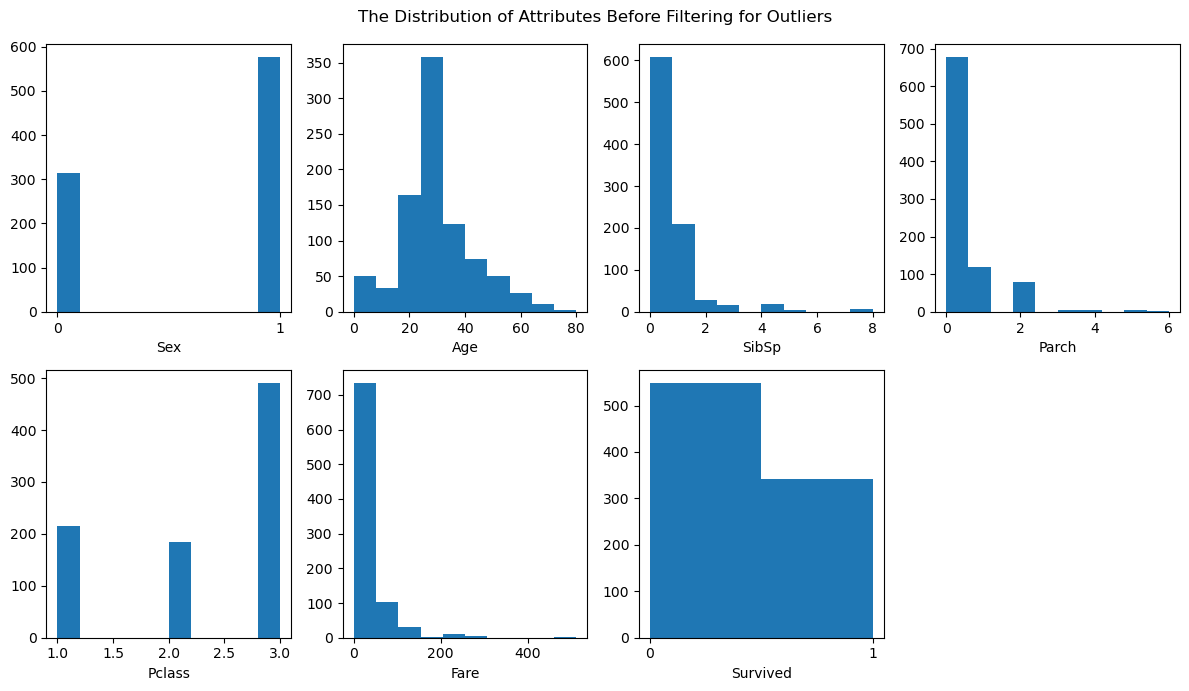

In [281]:
M = (len(refined_data.columns))
N = len(refined_data)
columns = refined_data.columns
plt.figure(figsize=(12, 7))
# units = ['mu U/ml','yrs','','','mm','kg/m^2','mmol/L','mm Hg','']
u = np.floor(np.sqrt(M))
v = np.ceil(float(M) / u)
limits = [600,600,600,300,300,300,400,400,400]
plt.suptitle('The Distribution of Attributes Before Filtering for Outliers')
print(M)
for i in range(M):

    plt.subplot(int(u), int(v), i + 1)
    plt.hist(refined_data[columns[i]],bins=(2 if columns[i]=='Survived' else 10))
    plt.xlabel(columns[i])
    if columns[i] in ['Survived','Sex']:
        plt.xticks([0,1])

    # plt.ylim(0,limits[i])

plt.tight_layout()
plt.show()


In [282]:
trainingAgeMean = refined_data['Age'].mean()
trainingAgeStd = refined_data['Age'].std()
refined_data['Age'] = (refined_data['Age'] - trainingAgeMean) / trainingAgeStd

# Log-transform 'Fare' using log(1+x) to handle zero/negative values
refined_data['Fare'] = np.log1p(refined_data['Fare'])
trainingFareMean = refined_data['Fare'].mean()
trainingFareStd = refined_data['Fare'].std()
refined_data['Fare'] = (refined_data['Fare'] - trainingFareMean) / trainingFareStd

7


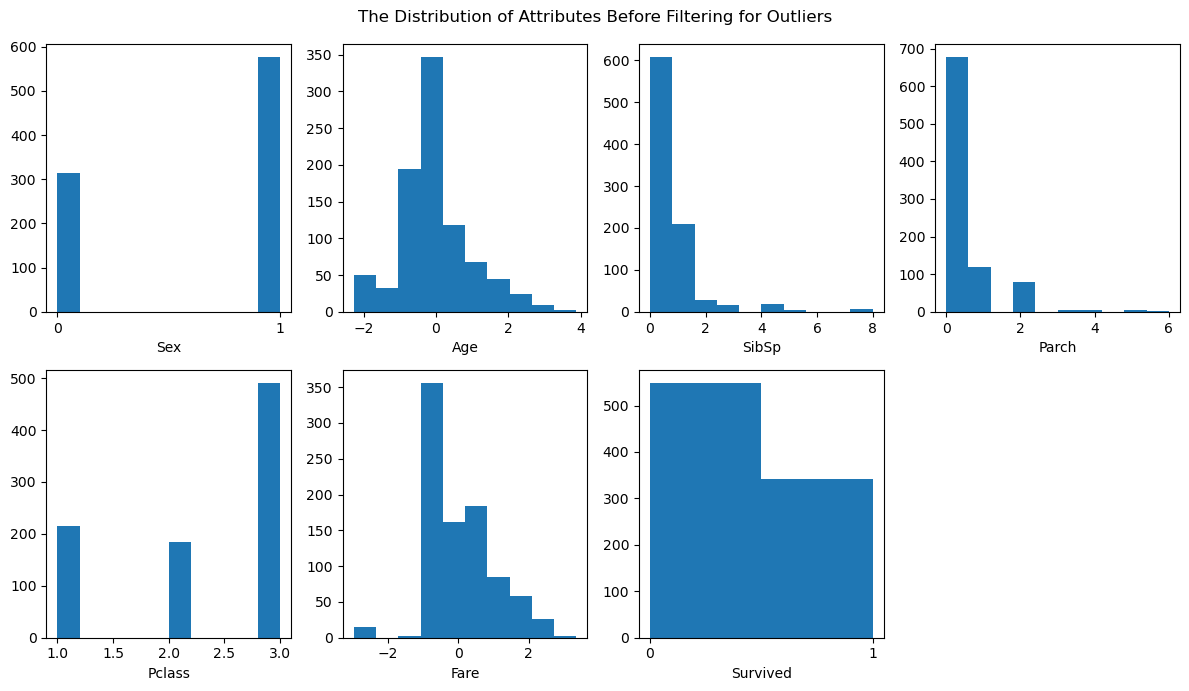

In [283]:
M = (len(refined_data.columns))
N = len(refined_data)
columns = refined_data.columns
plt.figure(figsize=(12, 7))
# units = ['mu U/ml','yrs','','','mm','kg/m^2','mmol/L','mm Hg','']
u = np.floor(np.sqrt(M))
v = np.ceil(float(M) / u)
limits = [600,600,600,300,300,300,400,400,400]
plt.suptitle('The Distribution of Attributes Before Filtering for Outliers')
print(M)
for i in range(M):

    plt.subplot(int(u), int(v), i + 1)
    plt.hist(refined_data[columns[i]],bins=(2 if columns[i]=='Survived' else 10))
    plt.xlabel(columns[i])
    if columns[i] in ['Survived','Sex']:
        plt.xticks([0,1])

    # plt.ylim(0,limits[i])

plt.tight_layout()
plt.show()

### Correlation Matrix Heatmap

In [284]:
refined_data

,Sex,Age,SibSp,Parch,Pclass,Fare,Survived
0,1,-0.579719,1,0,3,-0.862863,0
1,0,0.649747,1,0,1,1.363404,1
2,0,-0.272352,0,0,3,-0.862863,1
3,0,0.419222,1,0,1,1.071919,1
4,1,0.419222,0,0,3,-0.743523,0
...,...,...,...,...,...,...,...
886,1,-0.195511,0,0,2,-0.295850,0
887,0,-0.810244,0,0,1,0.509587,1
888,0,-0.041827,1,2,3,0.250270,0
889,1,-0.272352,0,0,1,0.509587,1


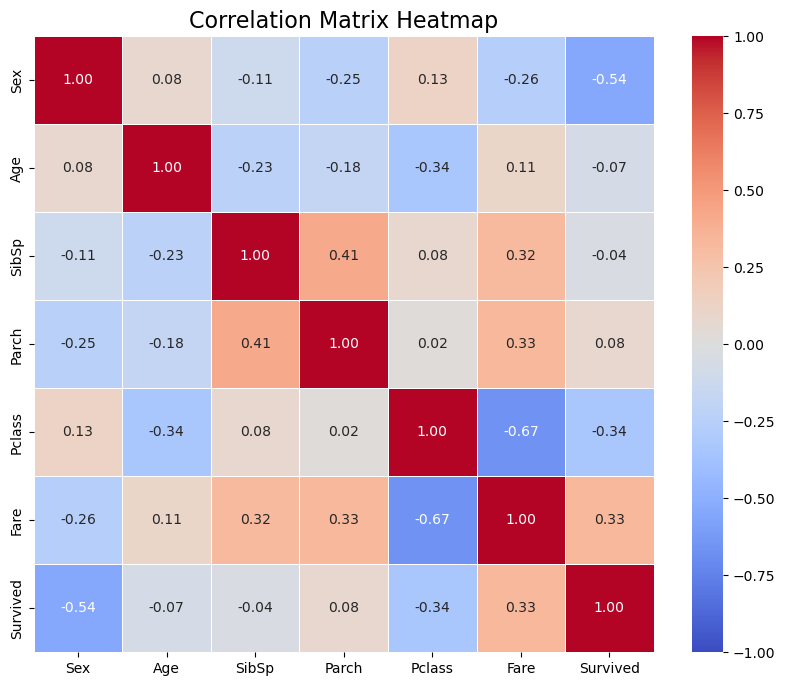

In [285]:
correlation_matrix = refined_data.corr()

plt.figure(figsize=(10, 8))

sb.heatmap(
    correlation_matrix, 
    annot=True,  
    fmt=".2f",   
    cmap="coolwarm",  
    vmin=-1, vmax=1, 
    linewidths=0.5,  
)


plt.title("Correlation Matrix Heatmap", fontsize=16)


plt.show()

### PCA test

In [286]:
X = refined_data.to_numpy()[:,:-1]
N = len(X[:,0])
print(N)
squigglyX = (X - np.ones((N, 1)) * X.mean(axis=0))/X.std(axis=0)
squigglyX = squigglyX
U, S, Vh = svd(squigglyX, full_matrices=False)
U = Matrix(U)
pcaHomemade = squigglyX @ Vh.T

# changing format back to panda dataframe
pca_dict = {}
for i in range(1, M): 
    pca_dict[f'PC{i}'] = pcaHomemade[:, i-1]


pca_df = pd.DataFrame(pca_dict)

display(pca_df)

891


,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.191410,0.884111,0.541788,-0.274608,-0.371271,0.119787
1,1.944257,-1.345241,-0.679912,-0.324504,-0.906579,0.079213
2,-0.778823,0.527541,-1.627812,0.237122,-0.445276,-0.046763
3,1.760363,-1.154757,-0.757294,-0.432136,-0.863504,0.299964
4,-1.437104,-0.105153,0.314287,0.412111,-0.001067,-0.250522
...,...,...,...,...,...,...
886,-0.670964,-0.486431,0.331921,-0.564394,0.286772,0.241496
887,1.059186,-0.727449,-1.418810,-1.297765,-0.011072,0.555551
888,1.306990,1.504362,-0.803511,1.347021,0.569434,-0.232453
889,0.324722,-1.248065,0.482724,-1.212501,0.464165,0.446020


### Projection onto PCAs

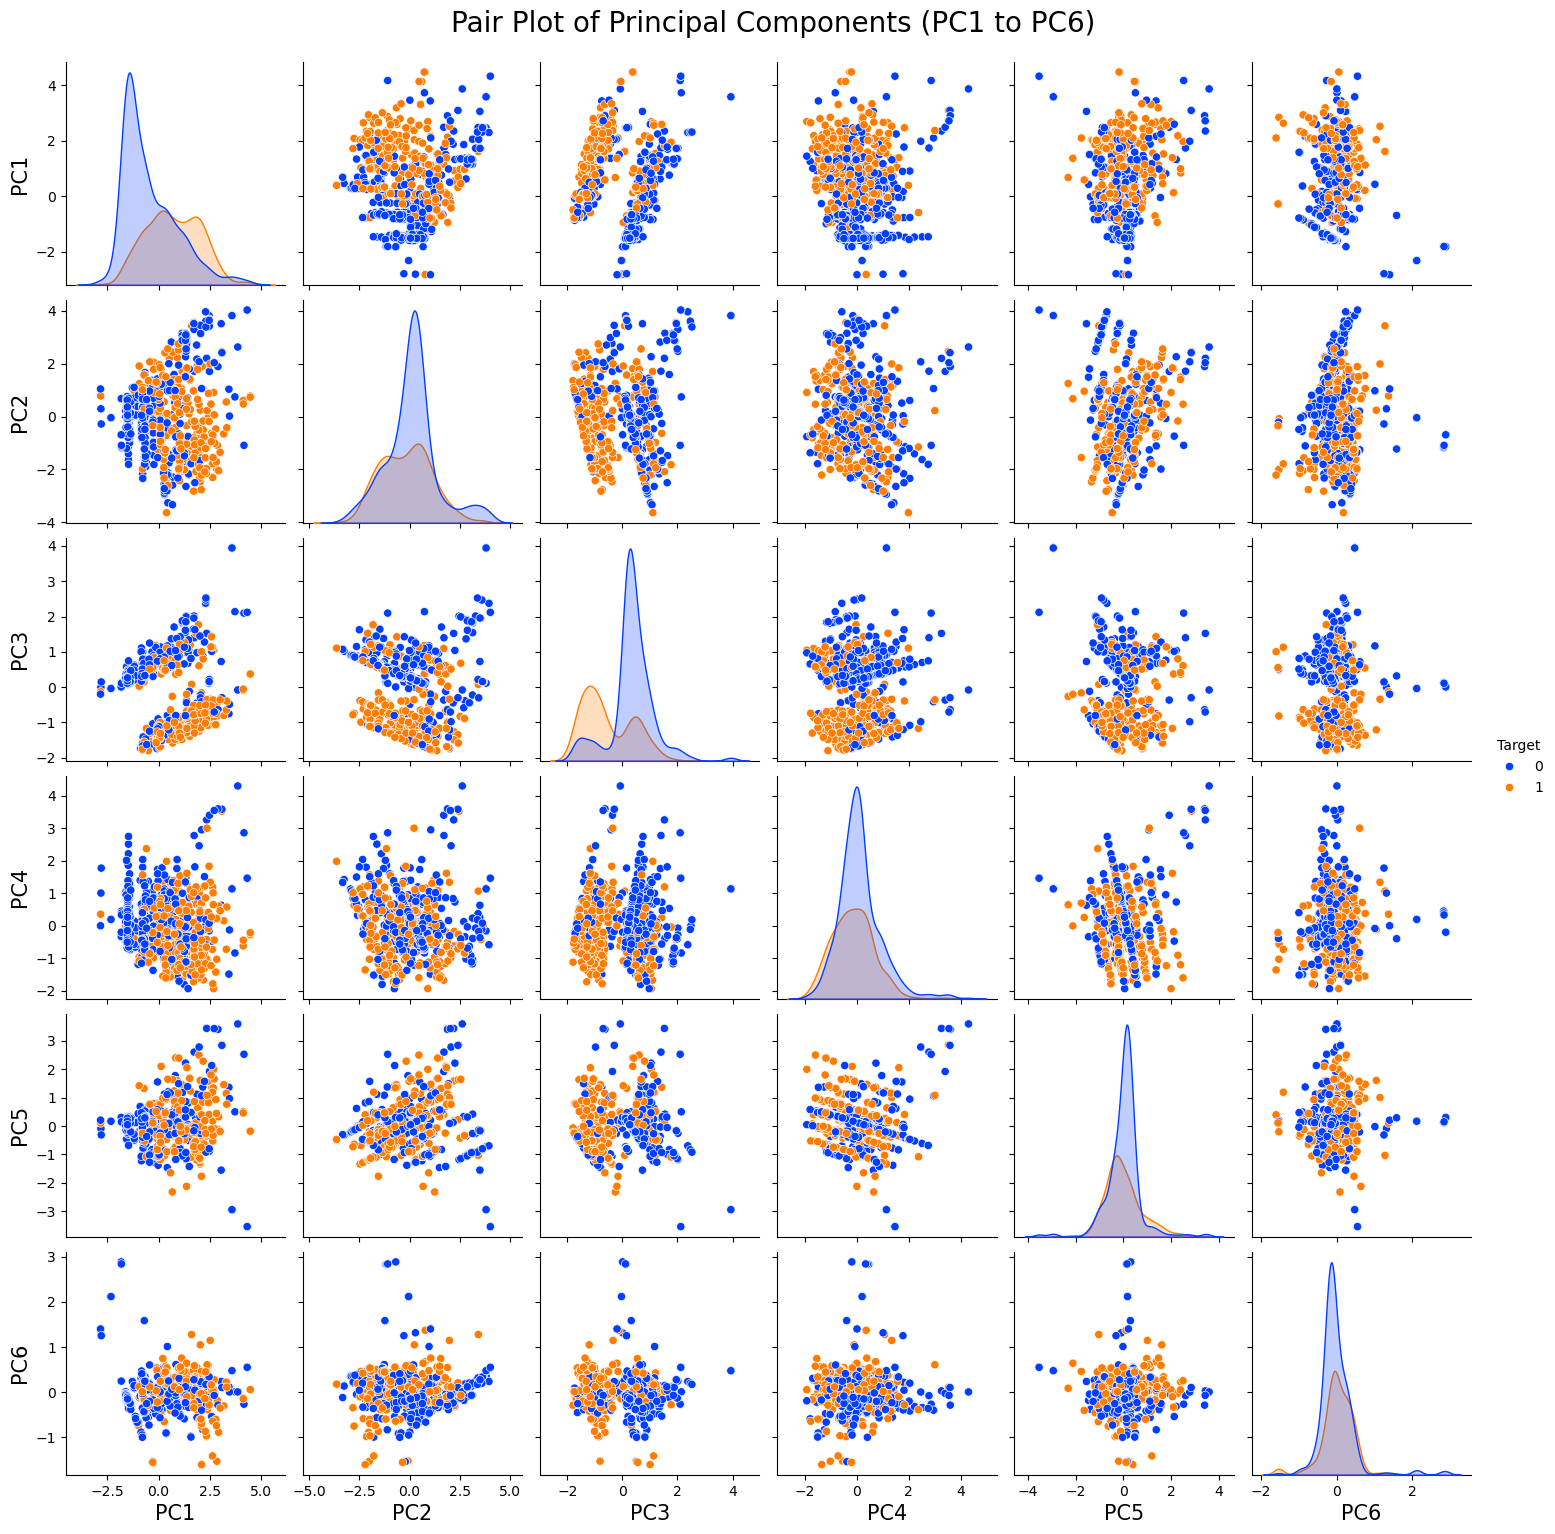

In [287]:
pca_df["Target"] = refined_data["Survived"]

pair_plot = sb.pairplot(
    pca_df,
    vars=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"],
    hue="Target",
    palette="bright",
    diag_kind="kde"
)

# labels
for i in range(6):
    for j in range(6):
        pair_plot.axes[i, j].set_xlabel(f"PC{j+1}", size=15)
        pair_plot.axes[i, j].set_ylabel(f"PC{i+1}", size=15)

# title
plt.suptitle("Pair Plot of Principal Components (PC1 to PC6)", y=1.02, size=20)
plt.show()

### Explained Variance by each PCA

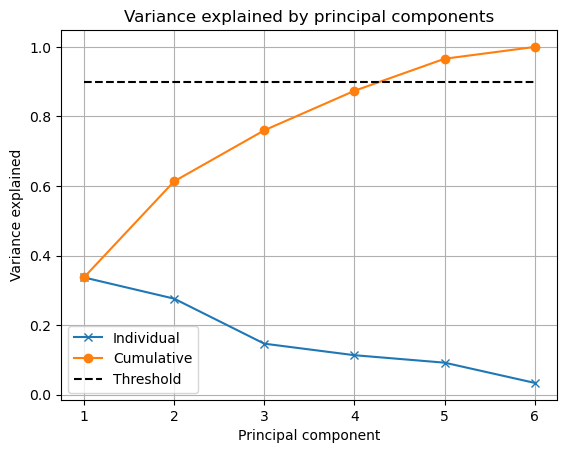

In [288]:
V = Vh.T

# Compute variance explained by principal components 
# Note: This is an important equation, see Eq. 3.18 on page 40 in the book.
rho = (S * S) / (S * S).sum()

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()
plt.show()

### 10 fold nested CV LogReg deepseek

In [318]:

# Define features and target
XLog = refined_data[['Sex', 'Age', 'SibSp', 'Parch', 'Pclass', 'Fare']]
yLog = refined_data['Survived']

# Convert lambda values to C values (C = 1/lambda)
lambda_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'C': [1/lam for lam in lambda_values]}  # C = 1/lambda

# Initialize nested cross-validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store results
results = []

# Outer loop
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner loop for hyperparameter tuning
    modelLog = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
    grid_search = GridSearchCV(modelLog, param_grid, cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get best parameters and validation error
    best_C = grid_search.best_params_['C']
    best_lambda = 1 / best_C  # Convert back to lambda
    validation_error = 1 - grid_search.best_score_
    
    # Store results
    results.append({
        'Fold': i+1,
        'Best Lambda': best_lambda,
        'Validation Error': validation_error
    })
    
    # Print results for this fold
    print(f"Outer Fold {i+1}:")
    print(f"  Best Lambda = {best_lambda:.6f}")
    print(f"  Validation Error = {validation_error:.4f}")
    print("-" * 40)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print("\nSummary of Nested Cross-Validation Results:")
print(results_df)

Outer Fold 1:
  Best Lambda = 10.000000
  Validation Error = 0.2073
----------------------------------------
Outer Fold 2:
  Best Lambda = 0.001000
  Validation Error = 0.1969
----------------------------------------
Outer Fold 3:
  Best Lambda = 1.000000
  Validation Error = 0.2033
----------------------------------------
Outer Fold 4:
  Best Lambda = 10.000000
  Validation Error = 0.2044
----------------------------------------
Outer Fold 5:
  Best Lambda = 10.000000
  Validation Error = 0.1945
----------------------------------------
Outer Fold 6:
  Best Lambda = 10.000000
  Validation Error = 0.1984
----------------------------------------
Outer Fold 7:
  Best Lambda = 1.000000
  Validation Error = 0.2045
----------------------------------------
Outer Fold 8:
  Best Lambda = 0.001000
  Validation Error = 0.2094
----------------------------------------
Outer Fold 9:
  Best Lambda = 10.000000
  Validation Error = 0.2057
----------------------------------------
Outer Fold 10:
  Best L


Starting Training with Holdout Validation (Test Size: 20%)
Epochs: 500, Batch Size: 1, Dropout Rate: 0.3
Learning Rate: 0.001, Weight Decay: 0.005
Model Architecture: Input -> Linear(8) -> ReLU -> Dropout(0.3) -> Linear(6) -> ReLU -> Dropout(0.3) -> Linear(1) -> Sigmoid

Epoch 1 out of 500
            Train Loss = 0.6905, Val Loss = 0.6755,
            Val Acc = 0.6145, Val Prec = 0.0000, Val AUC = 0.7329380764163373
Epoch 2 out of 500
            Train Loss = 0.6401, Val Loss = 0.5758,
            Val Acc = 0.6145, Val Prec = 0.0000, Val AUC = 0.8534914361001317
Epoch 3 out of 500
            Train Loss = 0.5689, Val Loss = 0.5477,
            Val Acc = 0.6145, Val Prec = 0.0000, Val AUC = 0.8466403162055337
Epoch 4 out of 500
            Train Loss = 0.5549, Val Loss = 0.5367,
            Val Acc = 0.8101, Val Prec = 0.8302, Val AUC = 0.838866930171278
Epoch 5 out of 500
            Train Loss = 0.5317, Val Loss = 0.5250,
            Val Acc = 0.8156, Val Prec = 0.8214, Val AUC = 0.

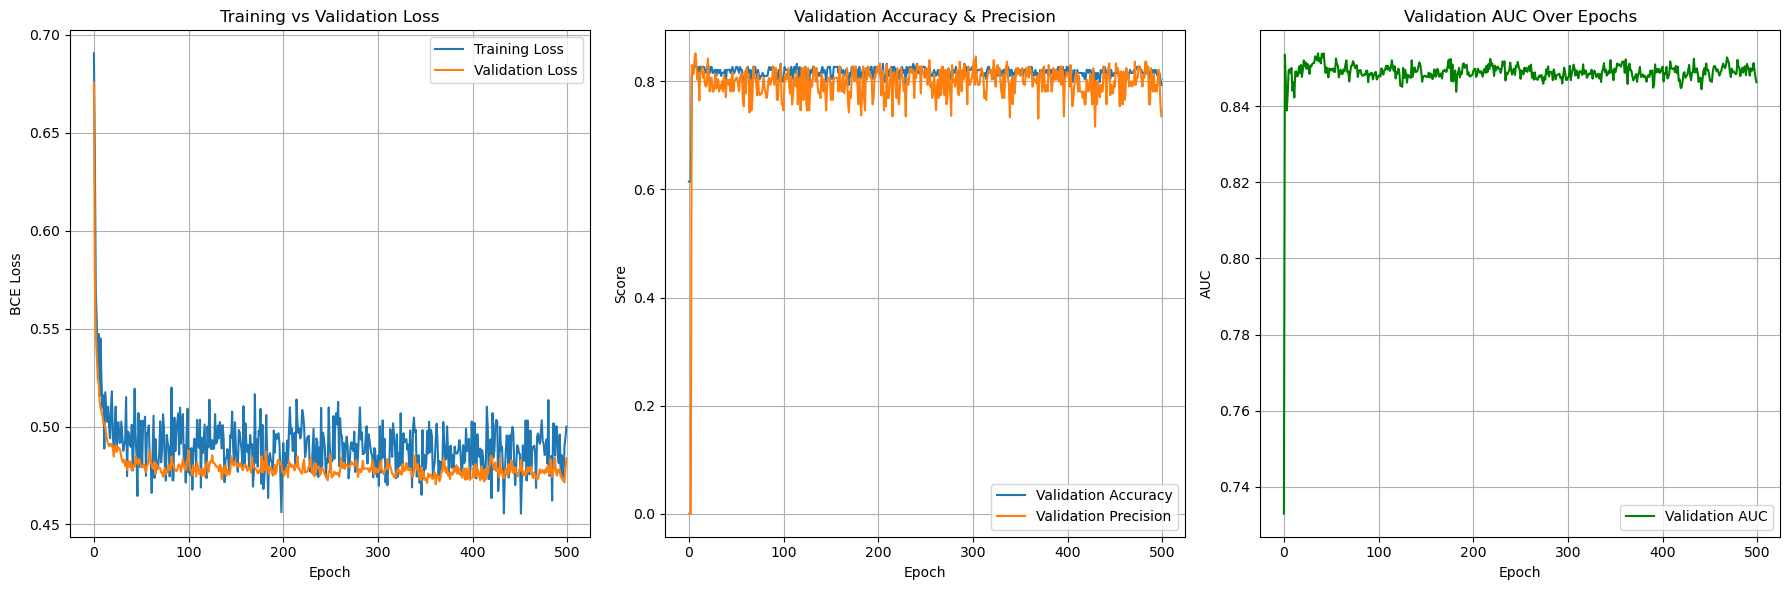


Summary Statistics (from final validation set evaluation):
  Validation Accuracy: 0.7933
  Validation Precision: 0.7353
  Validation AUC:      0.8463109354413703


In [290]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- Easily adjustable parameters ---
WEIGHT_DECAY = 0.005      # Increased for stronger regularization
EPOCHS = 500
BATCH_SIZE = 1         # Increased for more stable gradients
TEST_SIZE = 0.2
LEARNING_RATE = 0.001   # Kept, might need adjustment later
DROPOUT_RATE = 0.3       # Added dropout for regularization
# ------------------------------------

# --- Load your data here ---
# This is where you would load your 'refined_data' DataFrame
# For example:
# refined_data = pd.read_csv('path_to_your_titanic_refined_data.csv')

# For demonstration purposes, let's create dummy refined_data

# Prepare data
X_df = refined_data[['Sex', 'Age', 'SibSp', 'Parch', 'Pclass', 'Fare']]
y_series = refined_data['Survived']

# Ensure all columns are present, if not, raise an error or handle
required_cols = ['Sex', 'Age', 'SibSp', 'Parch', 'Pclass', 'Fare']
if not all(col in X_df.columns for col in required_cols):
    raise ValueError(f"DataFrame 'refined_data' must contain columns: {required_cols}")
if 'Survived' not in refined_data.columns:
    raise ValueError("DataFrame 'refined_data' must contain the 'Survived' column.")


X_values = X_df.values
y_values = y_series.values
X_values = X_values.astype(np.float32)
y_values = y_values.astype(np.float32)


# Define neural network architecture with Dropout
class RegularizedNN(nn.Module):
    def __init__(self, input_size, dropout_rate):
        super(RegularizedNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 8) # Reduced neurons
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(8, 6)         # Reduced neurons
        self.dropout2 = nn.Dropout(dropout_rate)
        self.output = nn.Linear(6, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        return torch.sigmoid(self.output(x))

# Training configuration
loss_fn = nn.BCELoss()

# For tracking training/validation errors and metrics
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_prec': [], 'val_auc': []}

# Holdout Validation: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_values, y_values, test_size=TEST_SIZE, random_state=42, stratify=y_values
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
train_data = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
)
val_data = torch.utils.data.TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# For validation, batch_size can be larger if memory allows, doesn't affect gradient updates
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


# Initialize model
input_size = X_train.shape[1]
model = RegularizedNN(input_size, DROPOUT_RATE) # Use the new model

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print(f"\n{'='*40}")
print(f"Starting Training with Holdout Validation (Test Size: {TEST_SIZE*100:.0f}%)")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Dropout Rate: {DROPOUT_RATE}")
print(f"Learning Rate: {LEARNING_RATE}, Weight Decay: {WEIGHT_DECAY}")
print(f"Model Architecture: Input -> Linear(8) -> ReLU -> Dropout({DROPOUT_RATE}) -> Linear(6) -> ReLU -> Dropout({DROPOUT_RATE}) -> Linear(1) -> Sigmoid")
print(f"{'='*40}\n")
models = []
# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train() # Set model to training mode (enables dropout)
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    history['train_loss'].append(avg_train_loss)

    # Validation phase
    model.eval() # Set model to evaluation mode (disables dropout)
    epoch_val_loss = 0.0
    all_val_targets_epoch = []
    all_val_outputs_probs_epoch = []
    models.append(model)
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
            all_val_targets_epoch.extend(targets.cpu().numpy())
            all_val_outputs_probs_epoch.extend(outputs.cpu().numpy())

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    history['val_loss'].append(avg_val_loss)

    all_val_targets_epoch_np = np.array(all_val_targets_epoch).flatten()
    all_val_outputs_probs_epoch_np = np.array(all_val_outputs_probs_epoch).flatten()

    pred_labels_epoch = (all_val_outputs_probs_epoch_np > 0.5).astype(int)
    val_acc = accuracy_score(all_val_targets_epoch_np, pred_labels_epoch)
    val_prec = precision_score(all_val_targets_epoch_np, pred_labels_epoch, zero_division=0)
    val_auc = np.nan
    if len(np.unique(all_val_targets_epoch_np)) > 1:
        try:
            val_auc = roc_auc_score(all_val_targets_epoch_np, all_val_outputs_probs_epoch_np)
        except ValueError as e:
            if epoch == 0 : print(f"Warning: AUC could not be computed for epoch {epoch+1}: {e}.") # Print warning only once if it persists
    else:
        if epoch == 0 : print(f"Warning: AUC not computed for epoch {epoch+1} due to only one class in validation targets.")

    history['val_acc'].append(val_acc)
    history['val_prec'].append(val_prec)
    history['val_auc'].append(val_auc)


    print(f"""Epoch {epoch+1} out of {EPOCHS}
            Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f},
            Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val AUC = {(val_auc) if not np.isnan(val_auc) else 'N/A'}""")

# Final evaluation
model.eval()
final_val_targets_list = []
final_val_outputs_probs_list = []
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        final_val_targets_list.extend(targets.cpu().numpy())
        final_val_outputs_probs_list.extend(outputs.cpu().numpy())

final_targets_np = np.array(final_val_targets_list).flatten()
final_predictions_probs_np = np.array(final_val_outputs_probs_list).flatten()
final_pred_labels = (final_predictions_probs_np > 0.5).astype(int)

final_val_acc = accuracy_score(final_targets_np, final_pred_labels)
final_val_prec = precision_score(final_targets_np, final_pred_labels, zero_division=0)
final_val_auc = np.nan
if len(np.unique(final_targets_np)) > 1:
    try:
        final_val_auc = roc_auc_score(final_targets_np, final_predictions_probs_np)
    except ValueError as e:
        print(f"Warning: Final AUC could not be computed: {e}")
else:
    print("Warning: Final AUC not computed due to only one class in the entire validation set.")

print(f"\n{'='*40}")
print("Final Validation Set Performance:")
print(f"  Accuracy:  {final_val_acc:.4f}")
print(f"  Precision: {final_val_prec:.4f}")
print(f"  AUC:       {(final_val_auc) if not np.isnan(final_val_auc) else 'N/A'}")
print(f"{'='*40}\n")

# Plot training history
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.plot(history['val_prec'], label='Validation Precision')
plt.title('Validation Accuracy & Precision')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Filter out NaNs for plotting AUC, as they can cause issues with plot limits
auc_to_plot = [x for x in history['val_auc'] if not np.isnan(x)]
epochs_for_auc = [i for i, x in enumerate(history['val_auc']) if not np.isnan(x)]
if epochs_for_auc: # Only plot if there are valid AUC values
    plt.plot(epochs_for_auc, auc_to_plot, label='Validation AUC', color='green')
else:
    plt.text(0.5, 0.5, 'AUC not computable for any epoch', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.title('Validation AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nSummary Statistics (from final validation set evaluation):")
print(f"  Validation Accuracy: {final_val_acc:.4f}")
print(f"  Validation Precision: {final_val_prec:.4f}")
print(f"  Validation AUC:      {final_val_auc if not np.isnan(final_val_auc) else 'N/A'}")

In [291]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
inputs
# outputs = models[3].(inputs)

tensor([[ 0.7424,  0.1048,  0.4783,  0.7278, -0.3709,  0.3777]])

In [293]:
columns = test_data.columns
refined_test = test_data.drop(['Name','Ticket','Cabin','PassengerId','Embarked'],axis=1)
refined_test

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,34.5,0,0,7.8292
1,3,female,47.0,1,0,7.0000
2,2,male,62.0,0,0,9.6875
3,3,male,27.0,0,0,8.6625
4,3,female,22.0,1,1,12.2875
...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500
414,1,female,39.0,0,0,108.9000
415,3,male,38.5,0,0,7.2500
416,3,male,NaN,0,0,8.0500


In [ ]:
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)

In [294]:
refined_test.isnull().any()

Pclass    False
Sex       False
Age        True
SibSp     False
Parch     False
Fare       True
dtype: bool

In [295]:
age_average = refined_test['Age'].mean()
refined_test['Age'] = refined_test['Age'].fillna(value=age_average)
age_average = refined_test['Fare'].mean()
refined_test['Fare'] = refined_test['Fare'].fillna(value=age_average)
refined_test.isnull().any()

Pclass    False
Sex       False
Age       False
SibSp     False
Parch     False
Fare      False
dtype: bool

In [296]:
if type(refined_test['Sex'][0]) is str :
    refined_test['Sex'] = (refined_test['Sex']=='male').astype(int)
refined_test = (refined_test).astype(int)
refined_test

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,34,0,0,7
1,3,0,47,1,0,7
2,2,1,62,0,0,9
3,3,1,27,0,0,8
4,3,0,22,1,1,12
...,...,...,...,...,...,...
413,3,1,30,0,0,8
414,1,0,39,0,0,108
415,3,1,38,0,0,7
416,3,1,30,0,0,8


In [298]:
columns = [  'Sex', 'Age', 'SibSp', 'Parch','Pclass', 'Fare']
refined_test = refined_test[columns]
refined_test.head()

,Sex,Age,SibSp,Parch,Pclass,Fare
0,1,34,0,0,3,7
1,0,47,1,0,3,7
2,1,62,0,0,2,9
3,1,27,0,0,3,8
4,0,22,1,1,3,12


In [299]:
refined_test['Age'] = (refined_test['Age'] - trainingAgeMean) / trainingAgeStd

# Log-transform 'Fare' using log(1+x) to handle zero/negative values
refined_test['Fare'] = np.log1p(refined_test['Fare'])

refined_test['Fare'] = (refined_test['Fare'] - trainingFareMean) / trainingFareStd

refined_test

,Sex,Age,SibSp,Parch,Pclass,Fare
0,1,0.342381,0,0,3,-0.862863
1,0,1.341322,1,0,3,-0.862863
2,1,2.493947,0,0,2,-0.636770
3,1,-0.195511,0,0,3,-0.743523
4,0,-0.579719,1,1,3,-0.370938
...,...,...,...,...,...,...
413,1,0.035014,0,0,3,-0.743523
414,0,0.726589,0,0,1,1.783567
415,1,0.649747,0,0,3,-0.862863
416,1,0.035014,0,0,3,-0.743523


In [312]:
inputs

tensor([[ 0.7424,  0.1048,  0.4783,  0.7278, -0.3709,  0.3777]])

In [311]:
refined_test.values[0]

array([ 1.        ,  0.3423808 ,  0.        ,  0.        ,  3.        ,
       -0.86286286])

In [330]:
torch.from_numpy(refined_test.values)

tensor([[ 1.0000,  0.3424,  0.0000,  0.0000,  3.0000, -0.8629],
        [ 0.0000,  1.3413,  1.0000,  0.0000,  3.0000, -0.8629],
        [ 1.0000,  2.4939,  0.0000,  0.0000,  2.0000, -0.6368],
        ...,
        [ 1.0000,  0.6497,  0.0000,  0.0000,  3.0000, -0.8629],
        [ 1.0000,  0.0350,  0.0000,  0.0000,  3.0000, -0.7435],
        [ 1.0000,  0.0350,  1.0000,  1.0000,  3.0000,  0.2071]],
       dtype=torch.float64)

In [370]:
modelLog = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000,C=1)


In [371]:
modelLog.fit(XLog,yLog)

LogisticRegression(C=1, max_iter=10000)

In [327]:
yLog

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int32

In [372]:
answerDf = pd.DataFrame(modelLog.predict(refined_test.values))

c:\Users\Ali\miniconda3\envs\dtu02450\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [373]:
answerDf['PassengerId'] = np.arange(892,1310)
answerDf

,0,PassengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,1,896
...,...,...
413,0,1305
414,1,1306
415,0,1307
416,0,1308


In [374]:
answerDf['Survived'] = answerDf.iloc[:, 0]
answerDf

,0,PassengerId,Survived
0,0,892,0
1,0,893,0
2,0,894,0
3,0,895,0
4,1,896,1
...,...,...,...
413,0,1305,0
414,1,1306,1
415,0,1307,0
416,0,1308,0


In [375]:
answerDf.drop(answerDf.columns[0], axis=1)
answerDf=answerDf[['PassengerId','Survived']]
answerDf

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [376]:
answerDf.to_csv('submission.csv', index=False)